
### Submitted By: Capstone Group 1 - AIML MAY Group - 3
### Project: AIML Online Capstone - Pneumonia Detection Challenge

#### OBJECTIVE
To build a pneumonia detection system, to locate the position of inflammation in an image.
#### CONTEXT
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
#### DATA DESCRIPTION
Dicom original images: - Medical images are stored in a special format called DICOM files (\*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

### Step 1 - Import the dataset.

Let us imports all required packages before importing dataset

In [2]:
# Adding imports required for data cleansing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

# Adding imports for misc and data prep
import os
import cv2
import pydicom #For displaying dcm images

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.6.2'

In [4]:
# Initialize the random number generator
import random

np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

from sklearn.model_selection import train_test_split

# NN Core imports
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPool2D
from tensorflow.keras.utils import to_categorical, plot_model

Importing the data

In [5]:
# Lets have a look at the dir structure
import os
for dirname, _, _ in os.walk('../input'):
    print(dirname)

../input
../input/rsna-pneumonia-detection-challenge
../input/rsna-pneumonia-detection-challenge/stage_2_train_images
../input/rsna-pneumonia-detection-challenge/stage_2_test_images


Define input path parameters

In [6]:
input_path = "../input/rsna-pneumonia-detection-challenge/"

train_img_path = input_path + 'stage_2_train_images/'
test_img_path = input_path + 'stage_2_test_images/'

# Contains information on the bounding box for each patient id
bounding_box = input_path + 'stage_2_train_labels.csv' 

# Contains detailed class saying whether data refers to Normal, Pneumonia or any other ailments
detailed_class_info = input_path + 'stage_2_detailed_class_info.csv'

# Contains the target data for which we need to train the images
sample_submission = input_path + 'stage_2_sample_submission.csv'

Read the label info data

In [7]:
bounding_box_df = pd.read_csv(bounding_box)
detailed_class_info_df = pd.read_csv(detailed_class_info)
sample_submission_df = pd.read_csv(sample_submission)

For each of the dataframe that is loaded, we are going to perform following,
- Check the shape of dataframe
- Sample content of dataframe
- Dataframe info check
- Duplicate check
- Write consolidated observations on each dataframe

#### Step 1.1 - Working with bounding_box dataframes

Shape of dataframe

In [8]:
print ("Shape of bounding_box dataframe is", bounding_box_df.shape)

Shape of bounding_box dataframe is (30227, 6)


Sample Content:

In [9]:
bounding_box_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Dataframe info:

In [10]:
bounding_box_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


- Data looks to be clean. No null values in any columns.
- 'patientId' columns is our key column in this data frame.

Duplicate check:

In [11]:
# Check for any duplicates in our key column
bounding_box_df['patientId'].is_unique

False

In [12]:
# Lets check out how many duplicates we have !
bounding_box_df_duplicate = bounding_box_df[bounding_box_df.duplicated(['patientId'])]
bounding_box_df_duplicate.shape

(3543, 6)

So we have around 3543 duplicate records of patientId's out of 30227 samples in the dataframe.

Following inferences can be made...
- So, do we have "30227-3543=26684" training images ? (one training image should be for one patient)
- That means, we should have multiple bounding boxes for one patient id, which makes sense for duplicate rows in bounding_box_df dataframe.

In [13]:
path, dirs, files = next(os.walk(train_img_path))
train_img_count = len(files)
train_img_count

26684

- Okay. So, we have 26684 unique patients and a total of 30227 bounding box data. 
- That confirms our assumption that there are multiple bounding boxes for some of the patient dcm images.

**Consolidated observations on train labels dataframe:**
- There are 30227 rows in this dataframe, which are infact bounding boxes data for various patientId's.
- We have 26684 dcm images for 30227 bounding box data. So, there are multiple bounding boxes in some patientId dcm files.
- Train label dataframe holds data which can be interpreted as,
   - patiendId column, having unique id assigned to each patient.
   - if Target is '1', i.e., if its a Pneumonia patient, 
       - we have bounding box co-ordinates with x, y, width and height
   - if Target is '0', i.e., if its NOT a pneumonia patient, 
       - we don't have bounding box co-ordinates

#### Step 1.2 - Working with detailed class info dataframes

Shape of dataframe

In [14]:
print ("Shape of detailed class info dataframe is", detailed_class_info_df.shape)

Shape of detailed class info dataframe is (30227, 2)


Sample Content:

In [15]:
detailed_class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Dataframe info:

In [16]:
detailed_class_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


- Data looks to be clean. No null values in any columns.
- 'patientId' columns is our key column in this data frame. Based on patientId, data in this dataframe relates to data in bounding_box_df (bounding box) dataframe.

Duplicate check:

In [17]:
# Check for any duplicates in our key column
detailed_class_info_df['patientId'].is_unique

False

In [18]:
# Lets check out how many duplicates we have !
detailed_class_info_df_duplicate = detailed_class_info_df[detailed_class_info_df.duplicated(['patientId'])]
detailed_class_info_df_duplicate.shape

(3543, 2)

Good to see that duplicate record count for patientId is 3543 and this exactly matches the duplicate count in bounding_box_df (bounding box) dataframe.

**Consolidated observations on detailed class info dataframes:**
- There are 30227 rows in this dataframe.
- There are 3543 duplicate records in this dataframe. This count exactly matches duplicate count in bounding_box_df (bounding box) dataframe.
- Above datafarme holds additional detailed information about the positive and negative classes (Target column) in the training set
- This data may be used to build more nuanced models, as including this information with training data will improve the FPR rate of our model and thereby our model will be more robust !
- So, let us merge bounding_box_df and detailed_class_info_df dataframes to have one single dataframe of interest.

**(Merge) Working with bounding-box and detailed-class-info dataframes**

Merge bounding_box_df and detailed_class_info_df dataframes

In [19]:
train_data_df = pd.concat([bounding_box_df, detailed_class_info_df['class']], axis = 1)
train_data_df.shape

(30227, 7)

Sample Content:

In [20]:
train_data_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


Now we have one single dataframe having details about bounding-box and detailed-class-info dataframes

#### Step 1.3 - Working with sample submission dataframes (target information dataframe)

Shape of dataframe

In [21]:
print ("Shape of sample_submission_df is", sample_submission_df.shape)

Shape of sample_submission_df is (3000, 2)


Sample Content:

In [22]:
sample_submission_df.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


Dataframe info:

In [23]:
sample_submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         3000 non-null   object
 1   PredictionString  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


- Target sample data as well looks clean. No null values in any columns.
- 'patientId' columns is our key column and this should relate to the test images that we have in the dataset.

Duplicate check:

In [24]:
# Check for any duplicates in our key column
sample_submission_df['patientId'].is_unique

True

- We have not got any duplicates in sample-submission dataframe. 
- This tells that we should as well have 3000 sample images in our test image directory.

In [25]:
path, dirs, files = next(os.walk(test_img_path))
test_img_count = len(files)
test_img_count

3000

- Okay. So, our test data set is clean.
- we have 3000 samples in the dataframe and 3000 images in the test image directory, which indicates that we have test images for all records in the test/target dataframe.

**Consolidated observations on train labels dataframe:**
- Target data is clean
   - There are 3000 records in sample-submission dataframe. 
   - 3000 record count in dataframe is exactly matching the number of test images in the dataset.
   - There are no duplicate records in the dataframe.
- sample-submission dataframe contains columns 'PredictionString' that holds the target (expected) bounding boxes for the test input dcm image.
- Sample content of 'PredictionString' columns is as,
  - 0.5 0 0 100 100
  - In the above data each value indicates following,
     - confidence-of-prediction bounding-box-x-coordinate bounding-box-y-coordinate width-of-bounding-box height-of-bounding-box
  - In above example,
     - confidence-of-prediction is 0.5
     - bounding-box-x-coordinate is 0
     - bounding-box-y-coordinate is 0
     - width-of-bounding-box is 100
     - height-of-bounding-box is 100

Note: One test image contains only one bounding boxes as reference. Prediction can have multiple bounding boxes detected.

### Step 2 - Data Visualization

#### Step 2.1 How balanced is our target data ?

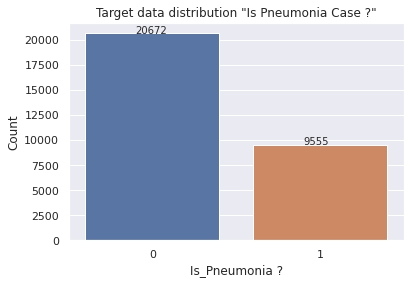

In [26]:
ax = sns.countplot(x="Target", data = bounding_box_df, label="Count");
plt.title('Target data distribution \"Is Pneumonia Case ?\"')
plt.xlabel('Is_Pneumonia ?')
plt.ylabel('Count')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))

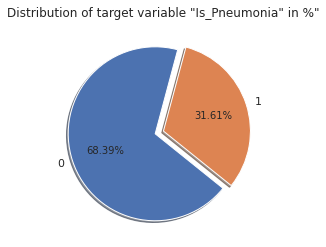

In [27]:
myexplode = [0.1, 0]
plt.pie(bounding_box_df['Target'].value_counts(), 
        labels=bounding_box_df['Target'].unique(), 
        explode=myexplode,
        startangle=75, 
        shadow = True, 
        autopct='%2.2f%%');
plt.title('Distribution of target variable \"Is_Pneumonia\" in %"');

#### Step 2.2 Class distribution in detailed_class_info dataframe

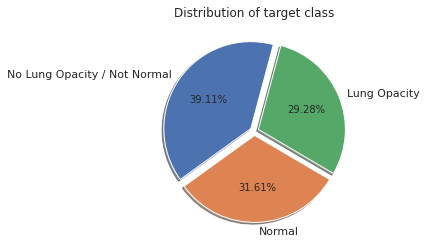

In [28]:
myexplode = [0.05, 0.05, 0.05]
plt.pie(detailed_class_info_df['class'].value_counts(), 
        labels=detailed_class_info_df['class'].unique(), 
        explode=myexplode,
        startangle=75, 
        shadow = True, 
        autopct='%2.2f%%');
plt.title('Distribution of target class');

Note: Normal class % (31.61) in detailed_class_info dataframe, matches with Normal class % (Target 0) in bounding_box dataframe

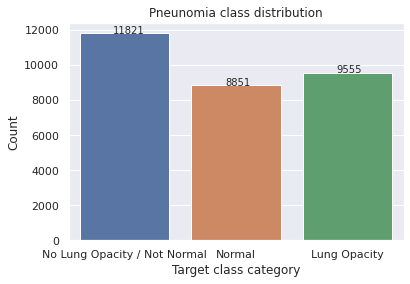

In [29]:
ax = sns.countplot(x='class', data = detailed_class_info_df, label="Count");
plt.title('Pneunomia class distribution')
plt.xlabel('Target class category')
plt.ylabel('Count')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))

We have good distrubution of all three classes in our dataset. Target class is balanced to good extent.

#### Step 2.3 Read and visualize sample dicom images

**-- Let us seggregate positive and negative cases from dataframe --**

In [30]:
# Get the dataframe having only POSITIVE cases
pos_df = train_data_df[(train_data_df['Target'] == 1)][['patientId', 'x', 'y', 'width', 'height', 'class']]
pos_df.head()

,patientId,x,y,width,height,class
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,Lung Opacity
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,Lung Opacity
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,Lung Opacity


In [31]:
# Get the dataframe having only NEGATIVE cases -> Target class - 'NORMAL'
neg_normal_df = train_data_df[(train_data_df['Target'] == 0) & (train_data_df['class'] == 'Normal')][['patientId', 'x', 'y', 'width', 'height', 'class']]
neg_normal_df.head()

,patientId,x,y,width,height,class
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,Normal
11,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,Normal
12,009eb222-eabc-4150-8121-d5a6d06b8ebf,NaN,NaN,NaN,NaN,Normal
13,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,NaN,NaN,NaN,NaN,Normal
21,00f87de5-5fe0-4921-93ea-914d7e683266,NaN,NaN,NaN,NaN,Normal


In [32]:
# Get the dataframe having only NEGATIVE cases -> Target class - 'NORMAL'
neg_not_normal_df = train_data_df[(train_data_df['Target'] == 0) & (train_data_df['class'] == 'No Lung Opacity / Not Normal')][['patientId', 'x', 'y', 'width', 'height', 'class']]
neg_not_normal_df.head()

,patientId,x,y,width,height,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal


**-- Define a method to take patient data and return the image with bounding box --**

In [33]:
# Method to read dcm image and then apply bounding box over it
def processImage(row, isPos):

    #Extract patientId
    pId = row['patientId']

    #Make the dcm image page for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array
    
    if (isPos):
        
        #Extract x1, y1 co-ordinates and width, height of bounding box
        x1, y1, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])

        #Apply bounding box co-ordinates and draw lines for the bounding box
        y2 = y1 + height
        x2 = x1 + width
        img[y1:y1 + 6, x1:x2] = 1
        img[y2:y2 + 6, x1:x2] = 1
        img[y1:y2, x1:x1 + 6] = 1
        img[y1:y2, x2:x2 + 6] = 1
    
    return img

**-- Visualize POSITIVE pneumonia cases --**

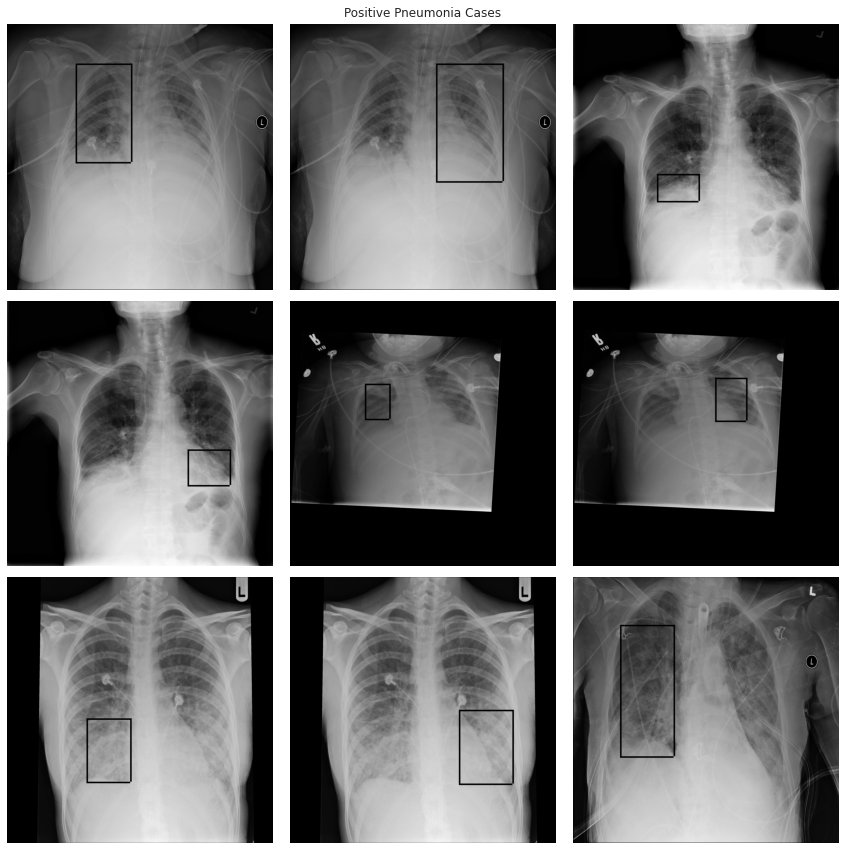

In [34]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Positive Pneumonia Cases')

for index, row in pos_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 1), cmap=plt.cm.gist_gray) 
plt.tight_layout()

**-- Visualize NEGATIVE pneumonia cases - 'No Lung Opacity / Not Normal' class category--**

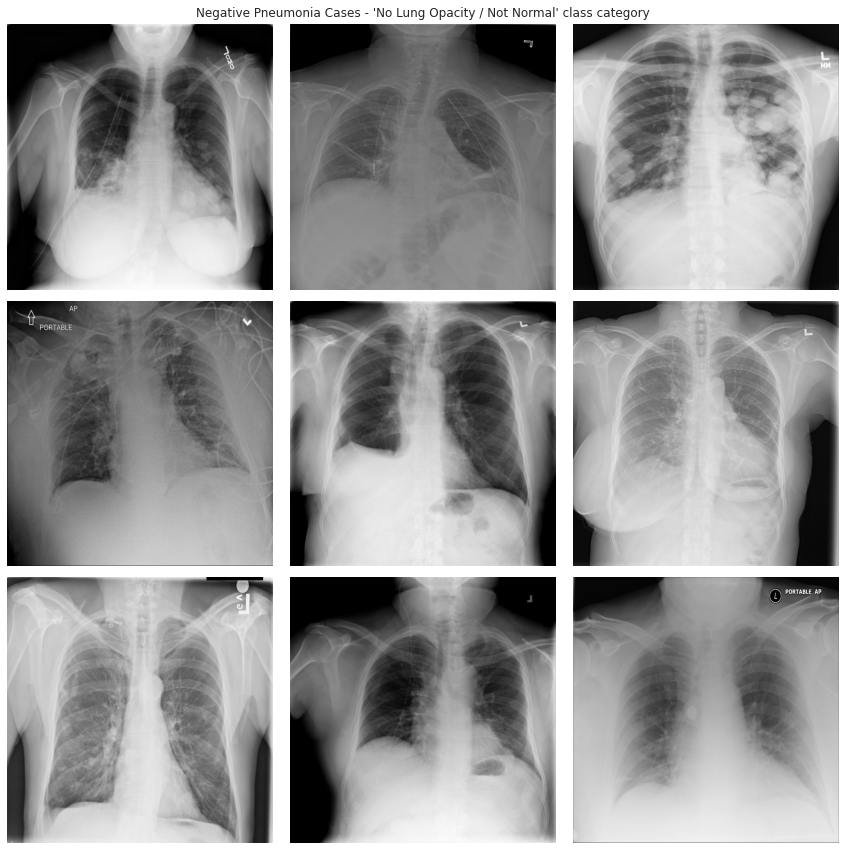

In [35]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Negative Pneumonia Cases - \'No Lung Opacity / Not Normal\' class category')

for index, row in neg_not_normal_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 0), cmap=plt.cm.gist_gray)
plt.tight_layout()

**-- Visualize NEGATIVE pneumonia cases - 'NORMAL' class category--**

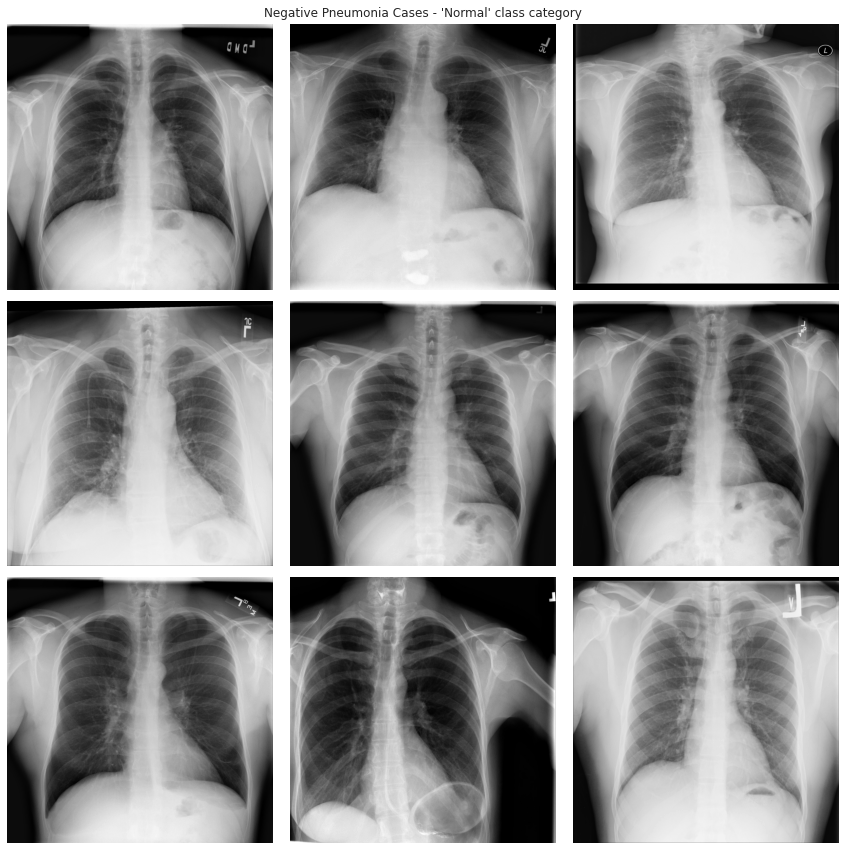

In [36]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Negative Pneumonia Cases - \'Normal\' class category')

for index, row in neg_normal_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 0), cmap=plt.cm.gist_gray)
plt.tight_layout()

### Step 3 - Data Modeling

- We need to load the image data in a format that can be used for model building and model evaluation
- This step will deal with loading the data into a form that is suitable for model building

In [37]:
train_data_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [38]:
# Replace all NaN's with 0's. This is required going forward for object detection.
# This will affect all records where 'Target = 0', 
# i.e., for Non-Pneunomic cases as bounding boxes are not applicable in those cases.
train_data_df.fillna(0, inplace=True)

In [39]:
# Let us stick to 1000 sample images for each class
sampleCount = 2000
train_sample_df = train_data_df.groupby('Target', group_keys=False).apply(lambda x: x.sample(sampleCount))
train_sample_df['Target'].value_counts()

0    2000
1    2000
Name: Target, dtype: int64

In [40]:
train_sample_df.describe()

,x,y,width,height,Target
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,198.478000,180.822500,109.187750,167.127750,0.500000
std,245.568986,208.926936,117.123283,201.609692,0.500063
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.500000,28.000000,31.000000,0.500000
75%,340.250000,355.000000,216.000000,308.000000,1.000000
max,816.000000,816.000000,445.000000,942.000000,1.000000


Data ranges for various fields looks to be in range and valid

In [41]:
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 21247 to 2947
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  4000 non-null   object 
 1   x          4000 non-null   float64
 2   y          4000 non-null   float64
 3   width      4000 non-null   float64
 4   height     4000 non-null   float64
 5   Target     4000 non-null   int64  
 6   class      4000 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 250.0+ KB


- So, Our sampled dataframe looks good with no non-null values.

Let us observe target split w.r.t., classes that we have in the data

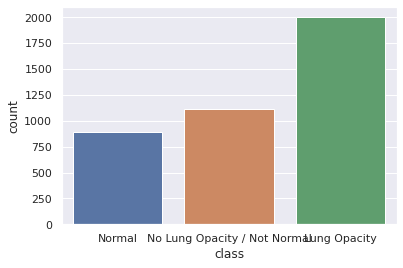

In [42]:
sns.countplot(train_sample_df['class']);

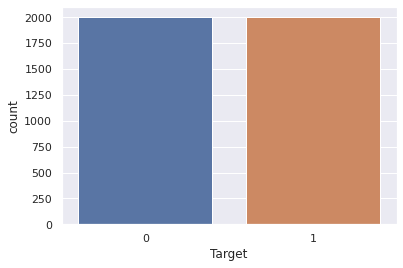

In [43]:
sns.countplot(train_sample_df['Target']);

#### Step 3.1 - Data preparation for data modeling

Load images and target classes into arrays

In [44]:
imageSize = 128
imgList = []
targetCatList = []

for index, eachRow in train_sample_df.iterrows():
    
    #Extract patientId
    pId = eachRow['patientId']
    targetCat = eachRow['Target']

    #Make the dcm image page for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array
    
    #Convert image to 3 channels
    img = np.stack([img] * 3, axis=2)
    
    #Resize image
    img = np.array(img).astype(np.uint8)
    img = cv2.resize(img, (imageSize, imageSize), interpolation = cv2.INTER_LINEAR)
    
    #Add image to target list
    imgList.append(img)
    targetCatList.append(targetCat)

#Convert list to array type (used for modeling)
imgArray = np.array(imgList)
targetCatArray = np.array(targetCatList)

In [45]:
imgArray.shape, targetCatArray.shape

((4000, 128, 128, 3), (4000,))

Encode target class array using a label encoder

In [46]:
from sklearn.preprocessing import LabelEncoder

# Create an object of LabelEncoder
le = LabelEncoder()

# Do fit_transform of target class of training data
targetCatEncoded = le.fit_transform(targetCatArray)

In [47]:
targetCatEncoded

array([0, 0, 0, ..., 1, 1, 1])

Now we have image data and target data encoded.

**- Let's split images/classes as train/test images -**
  - Let us have 60:40 split for train and validation set
  - Further from with in validation sample, lets split 50:50 for validation and test set
  - With this we have 60:20:20 split for Train, Validation and Test

In [48]:
X_train, X_test, y_train, y_test = train_test_split(imgArray, targetCatEncoded, test_size=0.4, random_state=1, stratify=targetCatEncoded)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, stratify=y_test)

print("Shape of X_train -> ", X_train.shape, ", Shape of y_train -> ", y_train.shape)
print("Shape of X_val -> ", X_val.shape, ", Shape of y_val -> ", y_val.shape)
print("Shape of X_test -> ", X_test.shape, ", Shape of y_test -> ", y_test.shape)

Shape of X_train ->  (2400, 128, 128, 3) , Shape of y_train ->  (2400,)
Shape of X_val ->  (800, 128, 128, 3) , Shape of y_val ->  (800,)
Shape of X_test ->  (800, 128, 128, 3) , Shape of y_test ->  (800,)


In [49]:
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [50]:
y_val

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

#### Step 3.2 - Basic model design

Let us do following steps,
1. Define model structure
2. Define callbacks and fit the model
3. Plot model stats on training and validation data
4. Model evaluation with test data with classification_report

#### Step 3.2.1 - Define model structure

In [51]:
# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

model_structure = Sequential()

# 2D convolution layer
model_structure.add(Conv2D(64, kernel_size=(3,3), input_shape = (imageSize, imageSize, 3), activation='relu'))
model_structure.add(MaxPool2D(pool_size = (2,2))) # Max Pool layer 
model_structure.add(BatchNormalization())

model_structure.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
model_structure.add(MaxPool2D(pool_size = (2,2)))
model_structure.add(BatchNormalization())

model_structure.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
model_structure.add(MaxPool2D(pool_size = (2,2)))

model_structure.add(Flatten())
model_structure.add(BatchNormalization())
model_structure.add(Dense(128, activation='relu'))
model_structure.add(Dropout(0.2))

model_structure.add(BatchNormalization())
model_structure.add(Dense(32, activation='relu'))
model_structure.add(Dense(2, activation='softmax'))

2022-04-25 16:03:22.725853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 16:03:22.828679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 16:03:22.829833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 16:03:22.832406: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [52]:
#To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

optimizer = Adam(lr=0.001)
model_structure.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_structure.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

#### Step 3.2.2 - Define callbacks and fit the model

In [53]:
#To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    EarlyStopping(monitor='val_loss', patience=5)
]

In [54]:
#To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

model_hist = model_structure.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    shuffle=False,
    verbose=1)

2022-04-25 16:03:26.398951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-25 16:03:28.505808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


75/75 [==============================] - 10s 20ms/step - loss: 0.6252 - accuracy: 0.6950 - val_loss: 2.7288 - val_accuracy: 0.5200
Epoch 2/10
75/75 [==============================] - 1s 17ms/step - loss: 0.5023 - accuracy: 0.7613 - val_loss: 0.6977 - val_accuracy: 0.6438
Epoch 3/10
75/75 [==============================] - 1s 17ms/step - loss: 0.4560 - accuracy: 0.7829 - val_loss: 0.6788 - val_accuracy: 0.6587
Epoch 4/10
75/75 [==============================] - 1s 16ms/step - loss: 0.4131 - accuracy: 0.8108 - val_loss: 0.7439 - val_accuracy: 0.6475
Epoch 5/10
75/75 [==============================] - 1s 16ms/step - loss: 0.3544 - accuracy: 0.8454 - val_loss: 0.8726 - val_accuracy: 0.5713
Epoch 6/10
75/75 [==============================] - 1s 16ms/step - loss: 0.2892 - accuracy: 0.8754 - val_loss: 0.5916 - val_accuracy: 0.7312
Epoch 7/10
75/75 [==============================] - 1s 17ms/step - loss: 0.2471 - accuracy: 0.8975 - val_loss: 0.7613 - val_accuracy: 0.6125
Epoch 8/10
75/75 [=====

#### Step 3.2.3 - Plot model stats on training and validation data

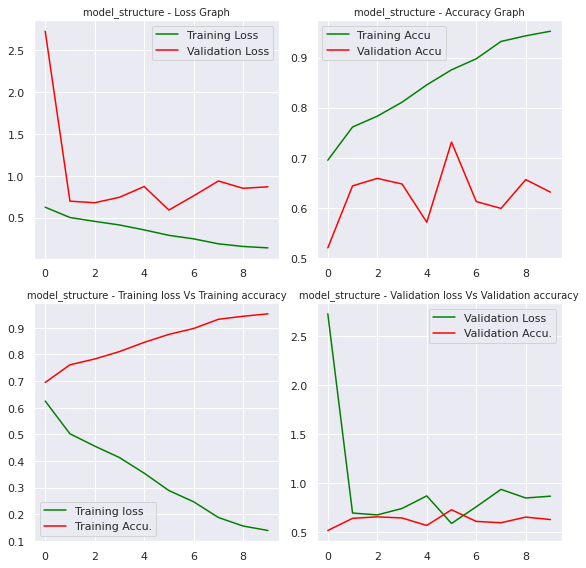

In [55]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ax[0, 0].set_title("model_structure - Loss Graph", fontsize=10)
ax[0, 0].plot(model_hist.history["loss"], color='green')
ax[0, 0].plot(model_hist.history["val_loss"], color='red')
ax[0, 0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[0, 1].set_title("model_structure - Accuracy Graph", fontsize=10)
ax[0, 1].plot(model_hist.history["accuracy"], color='green')
ax[0, 1].plot(model_hist.history["val_accuracy"], color='red')
ax[0, 1].legend(["Training Accu", "Validation Accu"], loc='best')

ax[1, 0].set_title("model_structure - Training loss Vs Training accuracy", fontsize=10)
ax[1, 0].plot(model_hist.history["loss"], color='green')
ax[1, 0].plot(model_hist.history["accuracy"], color='red')
ax[1, 0].legend(["Training loss", "Training Accu."], loc='best')

ax[1, 1].set_title("model_structure - Validation loss Vs Validation accuracy", fontsize=10)
ax[1, 1].plot(model_hist.history["val_loss"], color='green')
ax[1, 1].plot(model_hist.history["val_accuracy"], color='red')
ax[1, 1].legend(["Validation Loss", "Validation Accu."], loc='best')

plt.tight_layout()
plt.show()

#### Step 3.2.4 - Model evaluation with test data with classification_report

In [56]:
modelPerf = model_structure.evaluate(X_test, y_test)

25/25 [==============================] - 0s 5ms/step - loss: 0.8313 - accuracy: 0.6263


In [57]:
print ("Loss observed with test data is ->", round(modelPerf[0],4))
print ("Accuracy observed with test data is ->", round(modelPerf[1]*100,2), '%')

Loss observed with test data is -> 0.8313
Accuracy observed with test data is -> 62.63 %


In [58]:
from sklearn.metrics import classification_report

# Predict the values from the test dataset
Y_pred = model_structure.predict(X_test)

# Convert predicted and actual classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_actl_classes = np.argmax(y_test, axis = 1) 

print (classification_report(Y_actl_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.70      0.44      0.54       400
           1       0.59      0.81      0.68       400

    accuracy                           0.63       800
   macro avg       0.65      0.63      0.61       800
weighted avg       0.65      0.63      0.61       800



<font color=blue size=3>
    
<u>Base model Conclusion:</u><br>
- With this base model, we got Test data accuracy as <b>72%</b> and Test data loss as <b>0.81</b><br>
- We will perform RandomSearch and GridSearch with cross validation techniques to know which model performs better.

#### Step 3.3 - Model design with cross validation (RandomizedSearchCV)

Let us do following steps,
1. Define model structure and define cross validation parameters
2. Perform RandomizedSearch for various cross validation parameters
3. Get the best set of params
4. Redefine the model with best params and build the model (with predefined callbacks)
5. Plot model stats on training and validation data
6. Model evaluation with test data with classification_report

#### Step 3.3.1 - Define model structure and define cross validation parameters

In [ ]:
# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

def create_model(optimizer='adam', dropPct=0.2):
    cv_model = Sequential()

    # 2D convolution layer
    cv_model.add(Conv2D(64, kernel_size=(3,3), input_shape = (imageSize, imageSize, 3), activation='relu'))
    cv_model.add(MaxPool2D(pool_size = (2,2))) # Max Pool layer 
    cv_model.add(BatchNormalization())

    cv_model.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
    cv_model.add(MaxPool2D(pool_size = (2,2)))
    cv_model.add(BatchNormalization())

    cv_model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
    cv_model.add(MaxPool2D(pool_size = (2,2)))

    cv_model.add(Flatten())
    cv_model.add(BatchNormalization())
    cv_model.add(Dense(128, activation='relu'))
    cv_model.add(Dropout(dropPct))

    cv_model.add(BatchNormalization())
    cv_model.add(Dense(32, activation='relu'))
    cv_model.add(Dense(2, activation='softmax'))

    cv_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return cv_model

#### Step 3.3.2 - Perform RandomizedSearch for various cross validation parameters

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Nadam, Adamax, Adadelta

# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

# create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=1)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropPct = [0.1, 0.2, 0.3, 0.4, 0.5]
param_grid = dict(optimizer=optimizer, dropPct=dropPct)

randSearch = RandomizedSearchCV(estimator=model, 
                                param_distributions=param_grid, 
                                cv=3,
                                n_iter=20,
                                verbose=True, 
                                random_state=1)

randSearch_result = randSearch.fit(X_train, y_train,
                                   validation_data = (X_val, y_val),
                                   epochs=5,
                                   batch_size=32,
                                   callbacks=callbacks,
                                   shuffle=False,
                                   verbose=1)

#### Step 3.3.3 - Get the best set of params

In [ ]:
print("Best: %f using %s" % (randSearch_result.best_score_, randSearch_result.best_params_))

In [ ]:
randSearch_result_df = pd.DataFrame.from_dict(randSearch_result.cv_results_)
randSearch_result_df['params']
randSearch_result_df.sort_values(by='mean_test_score',ascending=False)[['mean_test_score','params']]

<font color=blue size=3>
    
<u>RandomSearchCV results:</u><br>
- From RandomSearchCV, we got best parameters as <b>SGD</b> optimizer with drop percentage as <b>0.3</b>
- This optimizer has performed well with mean test score as <b>73%</b>
- We will use fit this best model from RandomSearCV into the data to see how it performs with accuracy and loss.

#### Step 3.3.4 - Redefine the model with best params and build the model (with predefined callbacks)

In [ ]:
#To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

best_model_fromCV = create_model(randSearch_result.best_params_['optimizer'], randSearch_result.best_params_['dropPct'])

best_model_hist = best_model_fromCV.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    shuffle=False,
    verbose=1)

#### Step 3.3.5 - Plot model stats on training and validation data

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ax[0, 0].set_title("best_model_fromCV - Loss Graph", fontsize=10)
ax[0, 0].plot(best_model_hist.history["loss"], color='green')
ax[0, 0].plot(best_model_hist.history["val_loss"], color='red')
ax[0, 0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[0, 1].set_title("best_model_fromCV - Accuracy Graph", fontsize=10)
ax[0, 1].plot(best_model_hist.history["accuracy"], color='green')
ax[0, 1].plot(best_model_hist.history["val_accuracy"], color='red')
ax[0, 1].legend(["Training Accu", "Validation Accu"], loc='best')

ax[1, 0].set_title("best_model_fromCV - Training loss Vs Training accuracy", fontsize=10)
ax[1, 0].plot(best_model_hist.history["loss"], color='green')
ax[1, 0].plot(best_model_hist.history["accuracy"], color='red')
ax[1, 0].legend(["Training loss", "Training Accu."], loc='best')

ax[1, 1].set_title("best_model_fromCV - Validation loss Vs Validation accuracy", fontsize=10)
ax[1, 1].plot(best_model_hist.history["val_loss"], color='green')
ax[1, 1].plot(best_model_hist.history["val_accuracy"], color='red')
ax[1, 1].legend(["Validation Loss", "Validation Accu."], loc='best')

plt.tight_layout()
plt.show()

#### Step 3.3.6 - Model evaluation with test data with classification_report

In [ ]:
modelPerf_cv = best_model_fromCV.evaluate(X_test, y_test)

In [ ]:
print ("Loss observed with test data is ->", round(modelPerf_cv[0],4))
print ("Accuracy observed with test data is ->", round(modelPerf_cv[1]*100,2), '%')

In [ ]:
from sklearn.metrics import classification_report

# Predict the values from the test dataset
Y_pred = best_model_fromCV.predict(X_test)

# Convert predicted and actual classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_actl_classes = np.argmax(y_test, axis = 1) 

print (classification_report(Y_actl_classes, Y_pred_classes))

<font color=blue size=3>
    
<u>RandomSearchCV Conclusion:</u><br>
- Best parameters are <b>SGD</b> optimizer with drop percentage as <b>0.3</b>
- Test data accuracy is <b>78%</b> and Test data loss is <b>0.60</b>
- We got <b>better</b> accuracy and <b>inferior</b> loss compared to basic model.
- Let's see how GridSearchCV performs to find better params in below section

#### Step 3.4 - Model design with cross validation (GridSearch)

Let us do following steps,
- Note: Model structure ready (Already defined in last section during RandomizedSearchCV)
1. Perform GridSearchCV for various cross validation parameters
2. Get the best set of params
3. Redefine the model with best params and build the model (with predefined callbacks)
4. Plot model stats on training and validation data
5. Model evaluation with test data with classification_report

#### Step 3.4.1 - Perform GridSearchCV for various cross validation parameters

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Nadam, Adamax, Adadelta

# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropPct = [0.1, 0.2, 0.3, 0.4, 0.5]
param_grid = dict(optimizer=optimizer, dropPct=dropPct)

gridSearch = GridSearchCV(estimator=model, 
                                param_grid=param_grid, 
                                cv=5,
                                verbose=True)

gridSearch_result = gridSearch.fit(X_train, y_train,
                                   validation_data = (X_val, y_val),
                                   epochs=10,
                                   batch_size=32,
                                   callbacks=callbacks,
                                   shuffle=False,
                                   verbose=1)

#### Step 3.4.2 - Get the best set of params

In [ ]:
print("Best: %f using %s" % (gridSearch_result.best_score_, gridSearch_result.best_params_))

In [ ]:
gridSearch_result_df = pd.DataFrame.from_dict(gridSearch_result.cv_results_)
gridSearch_result_df['params']
gridSearch_result_df.sort_values(by='mean_test_score',ascending=False)[['mean_test_score','params']]

<font color=blue size=3>
    
<u>GridSearchCV results:</u><br>
- We got best parameters as <b>SGD</b> optimizer with drop percentage as <b>0.3</b>
- This optimizer has performed well with mean test score as <b>74%</b>
- We will use fit this best model from GridSearCV into the data to see how it performs with accuracy and loss.

#### Step 3.4.3 - Redefine the model with best params and build the model (with predefined callbacks)

In [ ]:
#To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

best_model_fromGridCV = create_model(gridSearch_result.best_params_['optimizer'], gridSearch_result.best_params_['dropPct'])

best_model_hist_grid = best_model_fromGridCV.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    shuffle=False,
    verbose=1)

#### Step 3.4.4 - Plot model stats on training and validation data

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ax[0, 0].set_title("best_model_fromGridCV - Loss Graph", fontsize=10)
ax[0, 0].plot(best_model_hist_grid.history["loss"], color='green')
ax[0, 0].plot(best_model_hist_grid.history["val_loss"], color='red')
ax[0, 0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[0, 1].set_title("best_model_fromGridCV - Accuracy Graph", fontsize=10)
ax[0, 1].plot(best_model_hist_grid.history["accuracy"], color='green')
ax[0, 1].plot(best_model_hist_grid.history["val_accuracy"], color='red')
ax[0, 1].legend(["Training Accu", "Validation Accu"], loc='best')

ax[1, 0].set_title("best_model_fromGridCV - Training loss Vs Training accuracy", fontsize=10)
ax[1, 0].plot(best_model_hist_grid.history["loss"], color='green')
ax[1, 0].plot(best_model_hist_grid.history["accuracy"], color='red')
ax[1, 0].legend(["Training loss", "Training Accu."], loc='best')

ax[1, 1].set_title("best_model_fromGridCV - Validation loss Vs Validation accuracy", fontsize=10)
ax[1, 1].plot(best_model_hist_grid.history["val_loss"], color='green')
ax[1, 1].plot(best_model_hist_grid.history["val_accuracy"], color='red')
ax[1, 1].legend(["Validation Loss", "Validation Accu."], loc='best')

plt.tight_layout()
plt.show()

#### Step 3.4.5 - Model evaluation with test data with classification_report

In [ ]:
modelPerf_grid_cv = best_model_fromGridCV.evaluate(X_test, y_test)

In [ ]:
print ("Loss observed with test data is ->", round(modelPerf_grid_cv[0],4))
print ("Accuracy observed with test data is ->", round(modelPerf_grid_cv[1]*100,2), '%')

In [ ]:
from sklearn.metrics import classification_report

# Predict the values from the test dataset
Y_pred = best_model_fromGridCV.predict(X_test)

# Convert predicted and actual classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_actl_classes = np.argmax(y_test, axis = 1) 

print (classification_report(Y_actl_classes, Y_pred_classes))

<font color=blue size=3>
    
<u>GridSearchCV Conclusion:</u><br>
- Best parameters are <b>SGD</b> optimizer with drop percentage as <b>0.3</b>
- Test data accuracy is <b>78%</b> and Test data loss is <b>0.6</b>
- We got same model as RandomSearchCV model.

<font color=brown size=4>
    
<u>Final Summary and Conclusion:</u><br><br>
    
<font color=blue size=3>

<u>Dataset Extraction and EDA</u><br>
- We have extracted given datasets and there were total of 30277 patient records available.
- The dataset had patientID, X, Y, height, width and Target columns in it. 
- The X, Y, height and width columns are representing bounding box details where pnuemonia is detected.
- There are 9555 records which doesn't have bounding box details as there is no pnuemonia detected in the same. 
- There are 3543 records which has more than one bounding box data which means for those patients there are more than one pnuemonia spots detected.
- So remaining 26684 unique patient records are available in the dataset
- Target as '1' means pnuemonia patient, where as '0' means not pnuemonia patient
- Here Patient ID is feature and Class is Target. And both the columns doesn't have null values in it.
- The class contains below
    - No Lung Opacity / Not Normal
    - Normal
    - Lung Opacity
- Lung Opacity class records are having pneumonia spots available for the patients, So Target must be 1
- Normal class records doesn't have pnemonia spots, so Target must be 0
- No Lung Opacity / Not Normal records doesn't have pnemonia spots as well as it doesn't have data whether patient has pnemonia or not. Since these data would be useful for model to predict well in terms of pnuemonia is detected or not. So we should not drop these records and Target must be 0
- We have 68% Target 0 records and 32% of Target 1 records
- We have visualized pneumonia patient records with bounding box where pneumonia is detected.
- We have visualized No pneumonia patient records from datasets

<font color=green size=3>

<u>Data Modeling</u><br>

- We got null values in x, y, height and width columns where pneumonia details are not present. So we replaced null values with 0.
- We took 2000 records each for both the Target values.
- We split the data as 60:20:20 for Train:Validation:Test data
- We created basic sequential model with Adam optimizer and categorical cross entrophy loss   
- We fitted the model with 10 epochs and batch size as 32    
    - We got Test accuracy as <b>72%</b> and loss as <b>0.81</b>
- We ought to do RandomSearchCV and GridSearchCV with cross validation to find out the best performing model for given data

<font color=blue size=3>

<u>RandomSearchCV cross validation results:</u><br>

- We have given below optimizers and drop percentages
    - 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
    - 0.1, 0.2, 0.3, 0.4, 0.5
- We got best parameters as <b>SGD</b> optimizer with drop percentage as <b>0.3</b>
- Test data accuracy is <b>78%</b> and Test data loss is <b>0.6</b>
- We got better accuracy and inferior loss compared to basic model
    
<font color=green size=3>
    
<u>GridSearchCV cross validation results:</u><br>

- We have given below optimizers and drop percentages
    - 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
    - 0.1, 0.2, 0.3, 0.4, 0.5
- We got best parameters as <b>SGD</b> optimizer with drop percentage as <b>0.3</b>
- Test data accuracy is <b>78%</b> and Test data loss is <b>0.6</b>
- We got same model as RandomSearchCV model.

### Step 4 - Image Detection (Self designed network from Scratch)

- Now is the time, we need to put bounding boxes on Pneumonia positive cases (i.e., cases where Target = 1)

#### Step 4.1 - Data preparation for model design

**- Verify couple of input image shapes -**
- Lets check the size/shape of dicom images. This will be required while loading and processing images for image detection.

In [115]:
train_sample_df.reset_index(inplace=True)

# Check shape/dimension of dicom images.
for index, eachRow in train_sample_df.iterrows():
    
    #Extract patientId
    pId = eachRow['patientId']

    #Make the dcm image path for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array
    print ("Image shape is", img.shape)
    
    if (index == 10):
        break

Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)
Image shape is (1024, 1024)


Observation: It is safe to assume that the dicom image shape is 1024 pixels

**- Input image pre-processing -**

Let us load training images and mask arrays

In [116]:
originalImageSize = 1024
imageSize = 128
no_of_images = train_sample_df.shape[0]

# Preparing an empty array for training images
training_images = np.zeros((no_of_images, imageSize, imageSize, 3))

# Preparing an empty array for masks
training_masks = np.zeros((no_of_images, imageSize, imageSize))

# Preparing an empty array for target labels
training_labels = np.zeros(no_of_images)

# Preparing an empty array to store coordinates
coordinates = np.zeros((no_of_images, 4))

for index, eachRow in train_sample_df.iterrows():

    #Extract patientId
    pId = eachRow['patientId']
    targetCat = eachRow['Target']

    #Make the dcm image page for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array

    #Convert image to 3 channels, Resize and load training image
    img = np.stack([img] * 3, axis=2)
    img = cv2.resize(img, (imageSize, imageSize), interpolation = cv2.INTER_LINEAR)
    training_images[index] = img
    
    #Load training mask
    x = int((eachRow['x'] / originalImageSize) * imageSize)
    y = int((eachRow['y'] / originalImageSize) * imageSize)
    height = int((eachRow['height'] / originalImageSize) * imageSize)
    width = int((eachRow['width'] / originalImageSize) * imageSize)
    training_masks[index][y:y+height, x:x+width] = 1
    
    #Record training labels
    training_labels[index] = targetCat
    
    #Record bounding box co-ordinates
    coordinates[index] = np.array([x, y, width, height])

**- Check shape of pre-processed images -**

In [117]:
print ("Shape of training_images is -> ", training_images.shape)
print ("Shape of training_masks is -> ", training_masks.shape)
print ("Shape of training_labels is -> ", training_labels.shape)
print ("Shape of bounding box co-ordinates array is -> ", coordinates.shape)

Shape of training_images is ->  (4000, 128, 128, 3)
Shape of training_masks is ->  (4000, 128, 128)
Shape of training_labels is ->  (4000,)
Shape of bounding box co-ordinates array is ->  (4000, 4)


**- Let's visualize test images and masks - For target 0 (Non-Pneunomia cases) -**

Out of 4000 samples, first 2000 samples are Non-Pneumonia cases

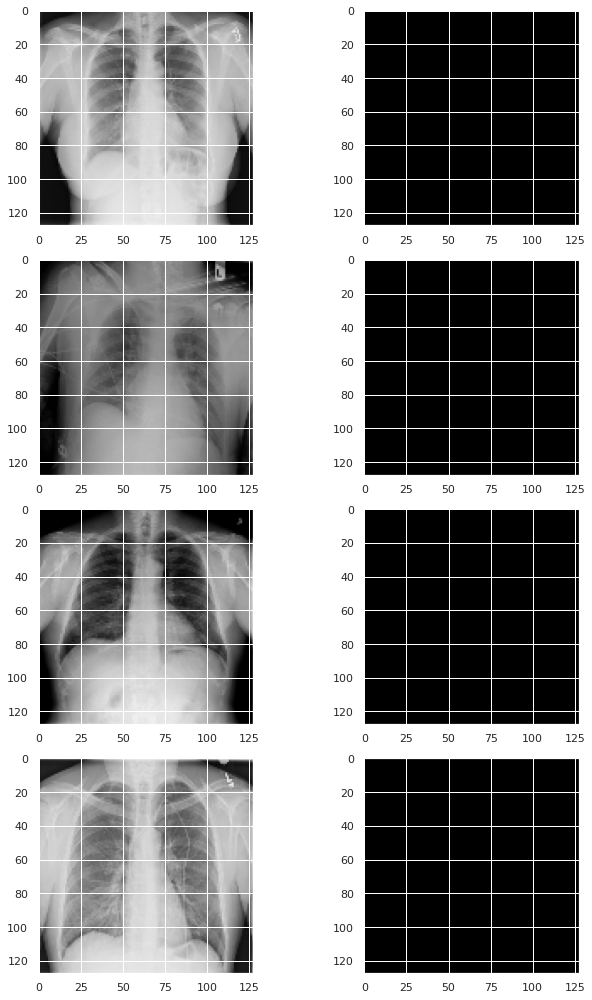

In [118]:
numOfRows = 4; # Number of samples to print
numOfCols = 2; # Two rows for display in each column. Index-0 for reference image and index-1 for related mask image

f, ax = plt.subplots(nrows=numOfRows, ncols=numOfCols, figsize=(10,14))
i=0;
for ro in range(0,4):
    ax[i, 0].imshow(training_images[ro].astype('uint8'), cmap=plt.cm.gist_gray);
    ax[i, 1].imshow(training_masks[ro], cmap=plt.cm.gist_gray);        
    i=i+1;
plt.tight_layout()
plt.show();

**- Let's visualize test images and masks - For target 1 (Pneunomia cases) -**

Out of 4000 samples, last 2000 samples are Pneumonia cases

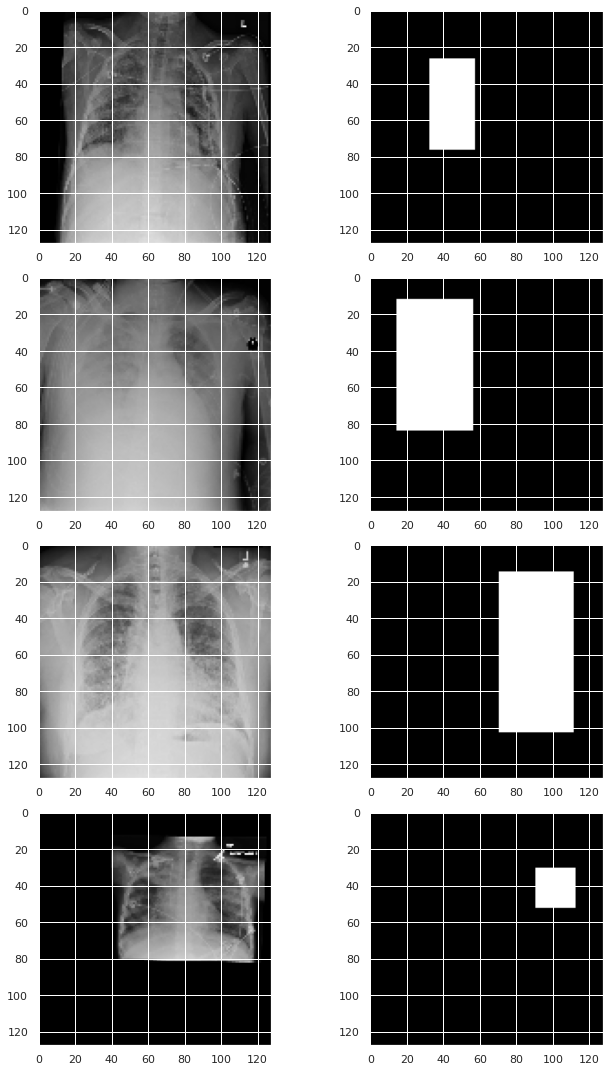

In [119]:
numOfRows = 4; # Number of samples to print
numOfCols = 2; # Two rows for display in each column. Index-0 for reference image and index-1 for related mask image

f, ax = plt.subplots(nrows=numOfRows, ncols=numOfCols, figsize=(10,15))
i=0;
for ro in range(2000, 2004):
    ax[i, 0].imshow(training_images[ro].astype('uint8'), cmap=plt.cm.gist_gray);
    ax[i, 1].imshow(training_masks[ro], cmap=plt.cm.gist_gray);        
    i=i+1;
plt.tight_layout()
plt.show();

**- Let's split images/masks as train/test images -**

In [120]:
X_train, X_test, y_train, y_test, train_label, test_label, train_coor, test_coor = train_test_split(
    training_images, 
    training_masks, 
    training_labels,
    coordinates,
    test_size=0.2, random_state=1, shuffle=False)

X_val, X_test, y_val, y_test, val_label, test_label, val_coor, test_coor = train_test_split(
    X_test, 
    y_test, 
    test_label,
    test_coor,
    test_size=0.2, random_state=1, shuffle=False)

print("Shape of X_train -> ", X_train.shape, ", Shape of y_train -> ", y_train.shape)
print("Shape of X_val -> ", X_val.shape, ", Shape of y_val -> ", y_val.shape)
print("Shape of X_test -> ", X_test.shape, ", Shape of y_test -> ", y_test.shape)
print("Shape of train_label -> ", train_label.shape, ", Shape of val_label -> ", val_label.shape, ", Shape of test_label is -> ", test_label.shape)
print("Shape of train_coor -> ", train_coor.shape, ", Shape of val_coor -> ", val_coor.shape, ", Shape of test_coor is -> ", test_coor.shape)

Shape of X_train ->  (3200, 128, 128, 3) , Shape of y_train ->  (3200, 128, 128)
Shape of X_val ->  (640, 128, 128, 3) , Shape of y_val ->  (640, 128, 128)
Shape of X_test ->  (160, 128, 128, 3) , Shape of y_test ->  (160, 128, 128)
Shape of train_label ->  (3200,) , Shape of val_label ->  (640,) , Shape of test_label is ->  (160,)
Shape of train_coor ->  (3200, 4) , Shape of val_coor ->  (640, 4) , Shape of test_coor is ->  (160, 4)


#### Step 4.2 - Model design

**- Let us write the basic model for image detection model -**

In [137]:
# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

# import tensorflow.keras.layers.Input
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import SGD

def create_model():
    
    #Create a sequential model
    detection_base_model = Sequential()

    # 2D convolution layer
    detection_base_model.add(Input(shape=(imageSize, imageSize, 3)))
    detection_base_model.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2))) # Max Pool layer 
    detection_base_model.add(BatchNormalization())

    detection_base_model.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2)))
    detection_base_model.add(BatchNormalization())

    detection_base_model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2)))
    detection_base_model.add(BatchNormalization())
    
    detection_base_model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2)))
    detection_base_model.add(BatchNormalization())

    detection_base_model.add(Conv2D(256, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2)))
    detection_base_model.add(BatchNormalization())

    flatten = Flatten()(detection_base_model.output)
    
    #Fully connected layer for Bounding Box detection (Regression)
    bb_reg = BatchNormalization()(flatten)
    bb_reg = Dense(256, activation='relu')(bb_reg)
    bb_reg = Dropout(0.2)(bb_reg)

    bb_reg = BatchNormalization()(bb_reg)
    bb_reg = Dense(128, activation='relu')(bb_reg)
    bb_reg = Dropout(0.2)(bb_reg)
    
    bb_reg = BatchNormalization()(bb_reg)
    bb_reg = Dense(64, activation='relu')(bb_reg)
    bb_reg = Dropout(0.2)(bb_reg)
    
    bb_reg = BatchNormalization()(bb_reg)
    bb_reg = Dense(32, activation='relu')(bb_reg)
    bb_reg = Dense(4, activation='linear', name='BB_Regression_Head')(bb_reg)

    #Fully connected layer for anamoly detection (Classification)
    target_classn = BatchNormalization()(flatten)
    target_classn = Dense(256, activation='relu')(target_classn)
    target_classn = Dropout(0.2)(target_classn)
    
    target_classn = BatchNormalization()(target_classn)
    target_classn = Dense(128, activation='relu')(target_classn)
    target_classn = Dropout(0.2)(target_classn)
    
    target_classn = BatchNormalization()(target_classn)
    target_classn = Dense(64, activation='relu')(target_classn)
    target_classn = Dropout(0.2)(target_classn)

    target_classn = BatchNormalization()(target_classn)
    target_classn = Dense(32, activation='relu')(target_classn)
    target_classn = Dense(1, activation='sigmoid', name='Target_Classification_Head')(target_classn)

    model = Model(inputs = detection_base_model.input, outputs = [bb_reg, target_classn])
    
    return model

In [138]:
# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

#Create the model
model = create_model()

#Define losses
losses = {
    "BB_Regression_Head": "mean_squared_error",
    "Target_Classification_Head": "binary_crossentropy"
}

#Define loss weights
loss_weights = {
    "BB_Regression_Head": 1.0,
    "Target_Classification_Head": 1.0
}

#Define metrics
metrics = {
    'BB_Regression_Head': 'mse',
    'Target_Classification_Head':  'accuracy'
}

# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5),
]

# Initialize Optimizer
optimizer = SGD(lr = 0.01, momentum = 0.9)

# Compile the model
model.compile(optimizer = optimizer, loss = losses, loss_weights = loss_weights, metrics = metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 126, 126, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 63, 63, 64)   0           conv2d_46[0][0]                  
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 63, 63, 64)   256         max_pooling2d_40[0][0]           
____________________________________________________________________________________________

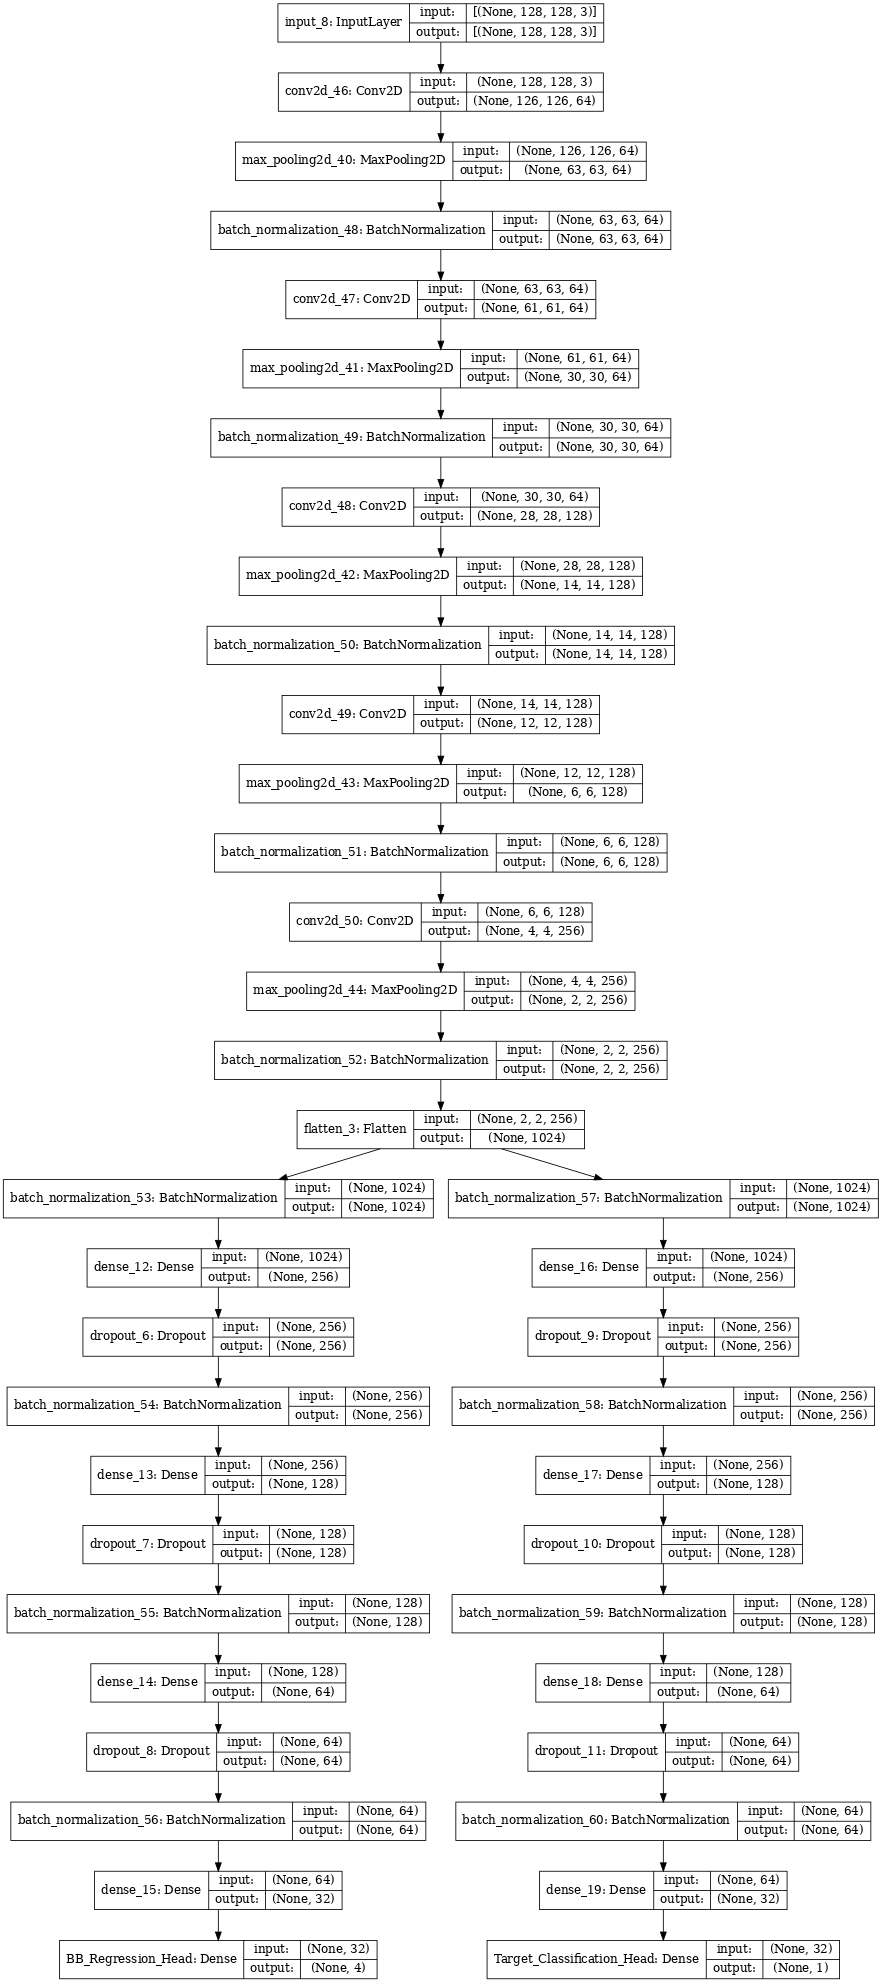

In [139]:
plot_model(model, 
           to_file='PneumoniaDetectionModel.png', 
           show_shapes=True, 
           show_layer_names=True, 
           rankdir='TB',
           dpi=60,
           layer_range=None)

In [140]:
# Train the Model
history = model.fit(x = X_train, 
                    y = {"BB_Regression_Head": train_coor, "Target_Classification_Head": train_label}, 
                    validation_data=(
                        X_val, 
                        {"BB_Regression_Head": val_coor, "Target_Classification_Head": val_label}
                    ), 
                    batch_size = 32, 
                    epochs = 50)

Epoch 1/50
100/100 [==============================] - 5s 30ms/step - loss: nan - BB_Regression_Head_loss: nan - Target_Classification_Head_loss: nan - BB_Regression_Head_mse: nan - Target_Classification_Head_accuracy: 0.6156 - val_loss: nan - val_BB_Regression_Head_loss: nan - val_Target_Classification_Head_loss: nan - val_BB_Regression_Head_mse: nan - val_Target_Classification_Head_accuracy: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 2s 18ms/step - loss: nan - BB_Regression_Head_loss: nan - Target_Classification_Head_loss: nan - BB_Regression_Head_mse: nan - Target_Classification_Head_accuracy: 0.6250 - val_loss: nan - val_BB_Regression_Head_loss: nan - val_Target_Classification_Head_loss: nan - val_BB_Regression_Head_mse: nan - val_Target_Classification_Head_accuracy: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 2s 18ms/step - loss: nan - BB_Regression_Head_loss: nan - Target_Classification_Head_loss: nan - BB_Regression_Head_mse: nan - Targe

### Step 5 - Image Detection (With transfer learning / U-Net model)
- Let us use mobilenet and build our pneumonia detection model (i.e., cases where Target = 1)

In [59]:
# Let us stick to 1000 sample images for each class
sampleCount = 500
train_sample_mn_df = train_data_df.groupby('Target', group_keys=False).apply(lambda x: x.sample(sampleCount))
train_sample_mn_df.reset_index(inplace=True)
train_sample_mn_df['Target'].value_counts()

0    500
1    500
Name: Target, dtype: int64

**- Defining hyper parameters and prepare data as required for mobilenet-**

In [60]:
# Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
ALPHA = 1

# Ref: https://arxiv.org/pdf/1704.04861.pdf (Mobilenet paper shows that expected input image size is 224x224x3)
IMAGE_SIZE = 224

In [61]:
originalImageSize = 1024
no_of_images = train_sample_mn_df.shape[0]

# Preparing an empty array for training images
training_images_mobnet = np.zeros((no_of_images, IMAGE_SIZE, IMAGE_SIZE, 3))

# Preparing an empty array for masks
training_masks_mobnet = np.zeros((no_of_images, IMAGE_SIZE, IMAGE_SIZE))

# Preparing an empty array for target labels
training_labels_mobnet = np.zeros(no_of_images)

# Preparing an empty array to store coordinates
coordinates_mobnet = np.zeros((no_of_images, 4))

for index, eachRow in train_sample_mn_df.iterrows():

    #Extract patientId
    pId = eachRow['patientId']
    targetCat = eachRow['Target']

    #Make the dcm image page for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array

    #Convert image to 3 channels, Resize and load training image
    img = np.stack([img] * 3, axis=2)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    training_images_mobnet[index] = img
    
    #Load training mask
    x = int((eachRow['x'] / originalImageSize) * IMAGE_SIZE)
    y = int((eachRow['y'] / originalImageSize) * IMAGE_SIZE)
    height = int((eachRow['height'] / originalImageSize) * IMAGE_SIZE)
    width = int((eachRow['width'] / originalImageSize) * IMAGE_SIZE)
    training_masks_mobnet[index][y:y+height, x:x+width] = 1
    
    #Record training labels
    training_labels_mobnet[index] = targetCat
    
    #Record bounding box co-ordinates
    coordinates_mobnet[index] = np.array([x, y, width, height])

**- Check shape of pre-processed images -**

In [62]:
print ("Shape of training_images is -> ", training_images_mobnet.shape)
print ("Shape of training_masks is -> ", training_masks_mobnet.shape)

Shape of training_images is ->  (1000, 224, 224, 3)
Shape of training_masks is ->  (1000, 224, 224)


In [63]:
X_train_mobnet, X_test_mobnet, y_train_mobnet, y_test_mobnet, train_label_mobnet, test_label_mobnet, train_coor_mobnet, test_coor_mobnet = train_test_split(
    training_images_mobnet, 
    training_masks_mobnet, 
    training_labels_mobnet,
    coordinates_mobnet,
    test_size=0.2, random_state=1, shuffle=False)

X_val_mobnet, X_test_mobnet, y_val_mobnet, y_test_mobnet, val_label_mobnet, test_label_mobnet, val_coor_mobnet, test_coor_mobnet = train_test_split(
    X_test_mobnet, 
    y_test_mobnet, 
    test_label_mobnet,
    test_coor_mobnet,
    test_size=0.2, random_state=1, shuffle=False)

print("Shape of X_train -> ", X_train_mobnet.shape, ", Shape of y_train -> ", y_train_mobnet.shape)
print("Shape of X_val -> ", X_val_mobnet.shape, ", Shape of y_val -> ", y_val_mobnet.shape)
print("Shape of X_test -> ", X_test_mobnet.shape, ", Shape of y_test -> ", y_test_mobnet.shape)
print("Shape of train_label -> ", train_label_mobnet.shape, ", Shape of val_label -> ", val_label_mobnet.shape, ", Shape of test_label is -> ", test_label_mobnet.shape)
print("Shape of train_coor -> ", train_coor_mobnet.shape, ", Shape of val_coor -> ", val_coor_mobnet.shape, ", Shape of test_coor is -> ", test_coor_mobnet.shape)

Shape of X_train ->  (800, 224, 224, 3) , Shape of y_train ->  (800, 224, 224)
Shape of X_val ->  (160, 224, 224, 3) , Shape of y_val ->  (160, 224, 224)
Shape of X_test ->  (40, 224, 224, 3) , Shape of y_test ->  (40, 224, 224)
Shape of train_label ->  (800,) , Shape of val_label ->  (160,) , Shape of test_label is ->  (40,)
Shape of train_coor ->  (800, 4) , Shape of val_coor ->  (160, 4) , Shape of test_coor is ->  (40, 4)


**- Let's design our model -**

In [64]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_SIZE, IMAGE_SIZE))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock)

**--Let us create out model now...**

In [65]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

model = create_model()

# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

**Design your own Dice Coefficient and Loss function.**

Define dice coefficient

In [66]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    # reduce_sum(), computes the sum of elements across dimensions of a tensor.
    # Since the 2nd arg, i.e., axis of reduce_sum() is 'None', it reduces all dimensions, 
    # and a tensor with a single element is returned.
    
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

Define Loss function

In [67]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

**Train, tune and test the model.**

Compile the model

In [68]:
# To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

# Defining optimizer and compile
optimizer = Adam(lr=0.001)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient, Recall(), Precision()])

# We need not compute Recall() and Precision() in image recognition, especially when we have dice_coefficient.
# We are still doing it as a good practice.

In [77]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    EarlyStopping(monitor='val_loss', patience=2)
]

Train the Model

In [83]:
#To get predictable results all the times
np.random.seed(0)
random.seed(0)
tensorflow.random.set_seed(0)

model.fit(
    X_train_mobnet,
    y_train_mobnet,
    validation_data = (X_val_mobnet, y_val_mobnet),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50


2022-04-25 16:06:57.267436: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 11.87GiB (rounded to 12742295552)requested by op model/up_sampling2d_4/resize/ResizeNearestNeighbor
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-25 16:06:57.267521: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-04-25 16:06:57.267556: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 147, Chunks in use: 147. 36.8KiB allocated for chunks. 36.8KiB in use in bin. 10.1KiB client-requested in use in bin.
2022-04-25 16:06:57.267576: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunks: 30, Chunks in use: 30. 15.5KiB allocated for chunks. 15.5KiB in use in bin. 15.0KiB client-request

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[32,224,224,1984] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/up_sampling2d_4/resize/ResizeNearestNeighbor (defined at tmp/ipykernel_597/1583512376.py:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[assert_greater_equal/Assert/AssertGuard/pivot_f/_3/_11]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) Resource exhausted:  OOM when allocating tensor with shape[32,224,224,1984] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/up_sampling2d_4/resize/ResizeNearestNeighbor (defined at tmp/ipykernel_597/1583512376.py:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_9322]

Function call stack:
train_function -> train_function


**Evaluate the model using testing data.**

In [ ]:
model.evaluate(X_test_mobnet, test_coor_mobnet)